In [117]:
import pandas as pd
import os, sys 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.vector_ar.vecm as vm
from itertools import combinations

In [118]:
sys.path.append(os.path.join(sys.path[3], 'algo_testing'))

In [14]:
from helpers.read_eco_data import preprocess

In [15]:
df = preprocess('../esg_data/esg_data.json')

In [17]:
df = df.loc[df['eco_score'] > 0]
df = df.reset_index(drop=True)

In [18]:
esg_df = df

In [19]:
stocks = pd.DataFrame()

for stock_name in df['ticker']:
    try: 
        temp = pd.read_json(f'../data/{stock_name}.json')
        new_df = pd.DataFrame({'date' : temp['t'], f'{stock_name}_price': temp['c']})
        new_df['date'] = pd.to_datetime(new_df['date'], unit='s')

        if stocks.empty: 
            stocks = new_df
        else: 
            stocks = pd.merge(stocks, new_df, how = 'outer', on='date')
    except Exception as e: 
        print(f"*** error reading {stock_name} : ", e)

*** error reading ADANIGR :  File ../data/ADANIGR.json does not exist
*** error reading ADANIT :  File ../data/ADANIT.json does not exist
*** error reading ADYAF :  File ../data/ADYAF.json does not exist
*** error reading AHLU :  File ../data/AHLU.json does not exist
*** error reading ALBK :  File ../data/ALBK.json does not exist
*** error reading ANDHRABANK :  File ../data/ANDHRABANK.json does not exist
*** error reading APCO :  File ../data/APCO.json does not exist
*** error reading AZRE :  File ../data/AZRE.json does not exist
*** error reading CARE :  File ../data/CARE.json does not exist
*** error reading  :  File ../data/.json does not exist
*** error reading CORPBANK :  File ../data/CORPBANK.json does not exist
*** error reading CRAFTSMA :  File ../data/CRAFTSMA.json does not exist
*** error reading DELHIVER :  File ../data/DELHIVER.json does not exist
*** error reading DLTA :  File ../data/DLTA.json does not exist
*** error reading EQUITAS :  File ../data/EQUITAS.json does not 

In [20]:
cleaned_stocks = pd.read_csv('../esg_data/cleaned_stocks.csv')

In [23]:
esg_data = pd.read_json('../esg_data/esg_data.json')
esg_data = esg_data[['ticker', 'industry']]

In [25]:
esg_df = pd.merge(esg_df, esg_data, how='left', on='ticker')

In [36]:
# count of each industry in esg_df
esg_df['industry'].value_counts()
# get industries with value count > 10
industries = esg_df['industry'].value_counts()[esg_df['industry'].value_counts() > 5].index.to_list()
print(industries)

['Diversified Financial Services', 'Banking', 'Heavy & Civil Engineering Construction', 'Motor Vehicle Parts Manufacturing', 'Real Estate Management & Development', 'Business Support Services', 'Manufacturing', 'Brokerage & Capital Markets', 'Food Products', 'Telecommunications', 'Motor Vehicle Manufacturing', 'Architectural, Engineering, & Related Services', 'IT & Network Services', 'Electric & Gas Utilities', 'Beverage Manufacturing', 'Insurance Carriers', 'Luxury Goods & Cosmetics Manufacturing', 'Containers & Packaging Manufacturing', 'Airport, Harbor Operations, & Logistics', 'Alternative Energy', 'Healthcare Providers', 'Consumer Lending', 'Conglomerates', 'Retail', 'Other Services', 'Natural Gas Distribution']


In [90]:
def do_johansen(sector, esg_df, cleaned_stocks, johansen_det_order = 0, johansen_k_ar_diff = 1): 
    sector_df = esg_df.loc[esg_df['industry'] == sector]
    sector_df = sector_df.reset_index(drop=True)
    # select the columns of cleaned_stocks that we want to use 
    cols = ([f'{stock}_price' for stock in sector_df['ticker'] 
             if f'{stock}_price' in cleaned_stocks.columns.to_list()])
    
    sector_stocks = cleaned_stocks[cols]
    # truncate sector_stocks to 12 columns if there are more than that
    if len(sector_stocks.columns) > 12: 
        sector_stocks = sector_stocks.iloc[:, :12]
        
    johansen_res = vm.coint_johansen(sector_stocks, det_order=johansen_det_order, k_ar_diff=johansen_k_ar_diff)
    
    johansen_df = (pd.Series({
        'eig_vecs': johansen_res.evec,
        'eig_vals': johansen_res.eig,
        'cvm': johansen_res.cvm,
        'cvt': johansen_res.cvt,
        'lr1': johansen_res.lr1,
        'lr2': johansen_res.lr2,
        'max_eig_stat': johansen_res.max_eig_stat,
        'max_eig_stat_crit_vals': johansen_res.max_eig_stat_crit_vals,
        'meth': johansen_res.meth,
        'r0t': johansen_res.r0t,
        'rkt': johansen_res.rkt,
        'trace_stat': johansen_res.trace_stat,
        'trace_stat_crit_vals': johansen_res.trace_stat_crit_vals
    }))
    
    return johansen_df

In [91]:
def check_crit_values(sector, esg_df, cleaned_stocks, crit_val = 2, johansen_det_order = 0, johansen_k_ar_diff = 1): 
    res = do_johansen(sector, esg_df, cleaned_stocks, johansen_det_order, johansen_k_ar_diff)
    
    max_i = -1
    for i in range(len(res.trace_stat)): 
        if(res.trace_stat[i] > res.trace_stat_crit_vals[i][crit_val]):
            max_i = max(max_i, i)
    
    print(f'{sector} : {max_i}')

In [92]:
for sector in industries: 
    try: 
        check_crit_values(sector, esg_df, cleaned_stocks)
    except Exception as e: 
        print(f"*** ERROR in {sector} : ", e)

Diversified Financial Services : 2
Banking : -1
Heavy & Civil Engineering Construction : 3
Motor Vehicle Parts Manufacturing : 2
Real Estate Management & Development : 2
*** ERROR in Business Support Services :  1-dimensional array given. Array must be at least two-dimensional
Manufacturing : 0
Brokerage & Capital Markets : -1
Food Products : -1
Telecommunications : 0
Motor Vehicle Manufacturing : -1
Architectural, Engineering, & Related Services : -1
IT & Network Services : 0
Electric & Gas Utilities : 0
Beverage Manufacturing : -1
*** ERROR in Insurance Carriers :  1-dimensional array given. Array must be at least two-dimensional
Luxury Goods & Cosmetics Manufacturing : 0
Containers & Packaging Manufacturing : -1
Airport, Harbor Operations, & Logistics : -1
Alternative Energy : 1
*** ERROR in Healthcare Providers :  1-dimensional array given. Array must be at least two-dimensional
Consumer Lending : -1
Conglomerates : -1
Retail : -1
*** ERROR in Other Services :  1-dimensional array 

In [85]:
johansen_df = do_johansen('Heavy & Civil Engineering Construction', esg_df, cleaned_stocks)

In [108]:
def check_johansen(sector, select_cols, esg_df, cleaned_stocks, johansen_det_order = 0, johansen_k_ar_diff = 1): 
    sector_df = esg_df.loc[esg_df['industry'] == sector]
    sector_df = sector_df.reset_index(drop=True)
    # select the columns of cleaned_stocks that we want to use 
    cols = ([f'{stock}_price' for stock in sector_df['ticker'] 
             if f'{stock}_price' in cleaned_stocks.columns.to_list()])
    
    sector_stocks = cleaned_stocks[cols]
    # truncate sector_stocks to 12 columns if there are more than that
    
    # select columns in select_cols
    sector_stocks = sector_stocks[select_cols]
        
        
    johansen_res = vm.coint_johansen(sector_stocks, det_order=johansen_det_order, k_ar_diff=johansen_k_ar_diff)
    
    johansen_df = (pd.Series({
        'eig_vecs': johansen_res.evec,
        'eig_vals': johansen_res.eig,
        'cvm': johansen_res.cvm,
        'cvt': johansen_res.cvt,
        'lr1': johansen_res.lr1,
        'lr2': johansen_res.lr2,
        'max_eig_stat': johansen_res.max_eig_stat,
        'max_eig_stat_crit_vals': johansen_res.max_eig_stat_crit_vals,
        'meth': johansen_res.meth,
        'r0t': johansen_res.r0t,
        'rkt': johansen_res.rkt,
        'trace_stat': johansen_res.trace_stat,
        'trace_stat_crit_vals': johansen_res.trace_stat_crit_vals
    }))
    
    return johansen_df

In [102]:
# Heavy & Civil Engineering Construction



sector_df = esg_df.loc[esg_df['industry'] == 'Heavy & Civil Engineering Construction']
sector_df = sector_df.reset_index(drop=True)
cols = ([f'{stock}_price' for stock in sector_df['ticker'] 
         if f'{stock}_price' in cleaned_stocks.columns.to_list()])

sector_stocks = cleaned_stocks[cols]

In [136]:
# generate all possible 4 stock combinations
combos = list(combinations(sector_stocks.columns, 4))
max_res = 0
max_combo = []

for combo in combos:
    combo = list(combo)
    res = check_johansen('Heavy & Civil Engineering Construction', combo, esg_df, cleaned_stocks)
    
    if res.trace_stat[3] > max_res: 
        max_res = res.trace_stat[3]
        max_combo = combo

In [137]:
res = check_johansen('Heavy & Civil Engineering Construction', max_combo, esg_df, cleaned_stocks)

In [138]:
print(res.trace_stat)


[79.25770855 27.12808875 15.07696395  6.28550311]


In [139]:
print(res.trace_stat_crit_vals)

[[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [140]:
print(res.eig_vals)

[0.02002557 0.0046655  0.0034057  0.00243611]


In [141]:
print(res.eig_vecs[0])

[ 0.00273918 -0.01025865 -0.03389192 -0.00116259]


In [142]:
max_combo.insert(0, 'date')

In [143]:
sector_stock_prices = cleaned_stocks[max_combo]

In [145]:
max_combo.remove('date')

In [146]:
sector_stock_prices['Portfolio'] = ( sector_stock_prices[max_combo]
                                    .mul(res.eig_vecs[0], axis=1)
                                    .sum(axis=1) ) 

C:\Users\esnd1\AppData\Local\Temp\ipykernel_17044\3447051722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_stock_prices['Portfolio'] = ( sector_stock_prices[max_combo]


In [149]:
from testers.stationarity import test_stationary

In [150]:
adf_res = test_stationary(sector_stock_prices['Portfolio'])

In [151]:
adf_res

ts         -2.835114
p           0.053430
nlags       1.000000
nobs     2577.000000
cv1        -3.432890
cv5        -2.862662
cv10       -2.567367
dtype: float64

In [159]:
def apo_based_trading(data): 
    # Variables/constants for EMA Calculation:
    NUM_PERIODS_FAST = 12 # Static time period parameter for the fast EMA
    K_FAST = 2 / (NUM_PERIODS_FAST + 1) 
    ema_fast = 0.0
    ema_fast_values = [] 
    
    NUM_PERIODS_SLOW = 26 # Static time period parameter for slow EMA
    K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) 
    ema_slow = 0.0
    ema_slow_values = [] 
    apo_values = []
    
    orders, positions, pnls = [], [], []
    last_buy_price = 0 
    last_sell_price = 0 
    position = 0 
    buy_sum_price_qty = 0
    buy_sum_qty = 0 
    sell_sum_price_qty = 0 
    sell_sum_qty = 0 
    open_pnl = 0 
    closed_pnl = 0 
    
    APO_VALUE_FOR_BUY_ENTRY = -10 
    APO_VALUE_FOR_SELL_ENTRY = 10 
    MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 
    MIN_PROFIT_TO_CLOSE = 10 
    NUM_SHARES_PER_TRADE = 10
    
    close = data['Price']
    for close_price in close:
        if ema_fast == 0: 
            ema_fast = close_price
            ema_slow = close_price
        else:
            ema_fast = (close_price - ema_fast) * K_FAST + ema_fast
            ema_slow = (close_price - ema_slow) * K_SLOW + ema_slow
        ema_fast_values.append(ema_fast)
        ema_slow_values.append(ema_slow)
        apo = ema_fast - ema_slow
        apo_values.append(apo)
        
        if ((apo > APO_VALUE_FOR_SELL_ENTRY and abs(close_price -
        last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)
        or
        (position > 0 and (apo >= 0 or open_pnl >
        MIN_PROFIT_TO_CLOSE))): 
            orders.append(-1) # mark the sell trade
            last_sell_price = close_price
            position -= NUM_SHARES_PER_TRADE # reduce position by the size of the trade
            sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
            sell_sum_qty += NUM_SHARES_PER_TRADE

        elif ((apo < APO_VALUE_FOR_BUY_ENTRY and abs(close_price -
        last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) 
        or
        (position < 0 and (apo <= 0 or open_pnl >
        MIN_PROFIT_TO_CLOSE))):
            orders.append(+1) 
            last_buy_price = close_price
            position += NUM_SHARES_PER_TRADE 
            buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) 
            buy_sum_qty += NUM_SHARES_PER_TRADE
        else:
            orders.append(0)
            
        positions.append(position)
        open_pnl = 0
        if position > 0:
            if sell_sum_qty > 0: 
                open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
                
                open_pnl += abs(sell_sum_qty - position) * (close_price -
                buy_sum_price_qty / buy_sum_qty)
        elif position < 0:
            if buy_sum_qty > 0:
                open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
                open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
        else:
            closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
            buy_sum_price_qty = 0
            buy_sum_qty = 0
            sell_sum_price_qty = 0
            sell_sum_qty = 0
            last_buy_price = 0
            last_sell_price = 0
        pnls.append(closed_pnl + open_pnl)
        
    data = data.assign(ClosePrice=pd.Series(close, index=data.index))
    data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values,
    index=data.index))
    data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values,
    index=data.index))
    data = data.assign(APO=pd.Series(apo_values, index=data.index))
    data = data.assign(Trades=pd.Series(orders, index=data.index))
    data = data.assign(Position=pd.Series(positions, index=data.index))
    data = data.assign(Pnl=pd.Series(pnls, index=data.index))

    return data

In [160]:
def analyze(new_df): 
    try: 
        # calculate drawdown
        new_df['max'] = new_df['Pnl'].cummax()
        new_df['drawdown'] = new_df['max'] - new_df['Pnl']
        plt.show()
        
        
        if new_df['Pnl'].mean() == 0.0:
            sharpe_ratio = 0
        else:
            sharpe_ratio = new_df['Pnl'].mean() / new_df['Pnl'].std()
        # calculate max drawdown
        max_drawdown = new_df['drawdown'].max()
        # # calculate max drawdown duration
        # max_drawdown_duration = new_df['drawdown'].idxmax() - new_df['drawdown'].idxmin()
        # calculate total return
        total_return = new_df['Pnl'].iloc[-1]
        # # calculate annualized return
        # annualized_return = new_df['Pnl'].iloc[-1] / len(new_df['Pnl']) * 252
        # # calculate annualized volatility
        # annualized_volatility = new_df['Pnl'].std() * np.sqrt(252)

        # calculate return percentage by dividing total reu
        # # calculate sortino ratio
        # sortino_ratio = new_df['Pnl'].mean() / new_df[new_df['Pnl'] < 0]['Pnl'].std()
        # # calculate calmar ratio
        # calmar_ratio = new_df['Pnl'].mean() / max_drawdown
        # # calculate average return
        # average_return = new_df['Pnl'].mean()
        # # calculate average loss
        # average_loss = new_df[new_df['Pnl'] < 0]['Pnl'].mean()
        # # calculate average win
        # average_win = new_df[new_df['Pnl'] > 0]['Pnl'].mean()
        # # calculate win rate
        # win_rate = len(new_df[new_df['Pnl'] > 0]['Pnl']) / len(new_df['Pnl'])
        # # calculate profit factor
        # profit_factor = new_df[new_df['Pnl'] > 0]['Pnl'].sum() / abs(new_df[new_df['Pnl'] < 0]['Pnl'].sum())
        # # create a dictionary using all the above variables that we have calculated
        
        
        # results = pd.Series({'sharpe_ratio': [sharpe_ratio], 'max_drawdown': [max_drawdown], 'max_drawdown_duration': [max_drawdown_duration], 'total_return': [total_return], 'annualized_return': [annualized_return], 'annualized_volatility': [annualized_volatility], 'sortino_ratio': [sortino_ratio], 'calmar_ratio': [calmar_ratio], 'average_return': [average_return], 'average_loss': [average_loss], 'average_win': [average_win], 'win_rate': [win_rate], 'profit_factor': [profit_factor]})
        results = pd.Series({'sharpe_ratio': [sharpe_ratio], 'max_drawdown': [max_drawdown], 'total_return': [total_return]})
       #  remove [] brackets from df
        results = results.apply(lambda x: x[0])
        return results
    
    except Exception as e: 
        print(e)

In [154]:
sector_stock_prices

,date,ASHOKA_price,GTLINFRA_price,HCC_price,IRB_price,Portfolio
0,2011-03-09,58.81,36.45,31.45,18.89,-1.300699
1,2011-03-10,57.78,36.45,32.43,18.62,-1.336420
2,2011-03-11,59.11,36.55,31.67,18.23,-1.307592
3,2011-03-14,60.79,36.60,31.54,18.53,-1.299446
4,2011-03-15,60.04,36.60,30.95,18.19,-1.281109
...,...,...,...,...,...,...
2574,2023-07-24,94.50,0.75,20.15,25.60,-0.461526
2575,2023-07-31,99.85,0.80,19.40,26.45,-0.422953
2576,2023-08-07,104.20,0.75,20.55,25.85,-0.448803
2577,2023-08-14,91.10,0.80,25.80,26.05,-0.663364


In [157]:
prices = sector_stock_prices['Portfolio']

<Axes: >

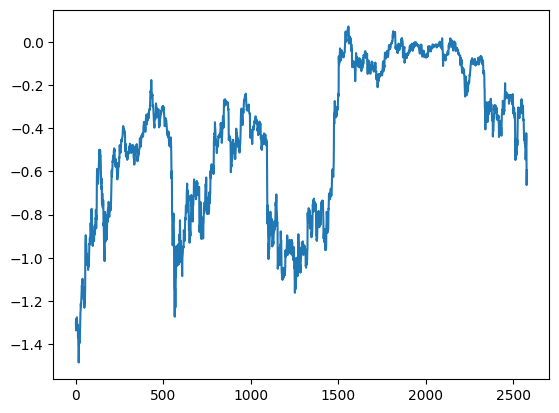

In [161]:
new_df = pd.DataFrame({'Price': sector_stock_prices['Portfolio']})
new_df = apo_based_trading(new_df)

print(new_df)
try: 
    res = analyze(new_df)
    print(res)
        
except Exception as e: 
    print(f"*** error analyzing : ", e)

         Price  ClosePrice  Fast10DayEMA  Slow40DayEMA       APO  Trades  \
0    -1.300699   -1.300699     -1.300699     -1.300699  0.000000       0   
1    -1.336420   -1.336420     -1.306194     -1.303345 -0.002850       0   
2    -1.307592   -1.307592     -1.306409     -1.303659 -0.002750       0   
3    -1.299446   -1.299446     -1.305338     -1.303347 -0.001991       0   
4    -1.281109   -1.281109     -1.301610     -1.301700  0.000090       0   
...        ...         ...           ...           ...       ...     ...   
2574 -0.461526   -0.461526     -0.464544     -0.424306 -0.040238       0   
2575 -0.422953   -0.422953     -0.458146     -0.424206 -0.033940       0   
2576 -0.448803   -0.448803     -0.456708     -0.426028 -0.030680       0   
2577 -0.663364   -0.663364     -0.488501     -0.443608 -0.044893       0   
2578 -0.595083   -0.595083     -0.504899     -0.454829 -0.050070       0   

      Position  Pnl  
0            0    0  
1            0    0  
2            0    0  